## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
# %matplotlib notebook
# matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils
importlib.reload(data)

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()
#     structure_eigvals_t, structure_coefficients_t, reconstructed_ldos_t = data.load_structure_gaussians()


ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


In [5]:
def manual_call(spline_coefs, spline_positions, x):
    """
    spline_coefs: shape of (n x 4 x spline_positions)
    
    return value: shape of (n x x)
    """
    interval = torch.round(spline_positions[1] - spline_positions[0], decimals = 4)
    indexes = torch.floor((x - spline_positions[0])/interval).long()
    x_1 = x - spline_positions[indexes]
    x_2 = x_1 * x_1
    x_3 = x_2 * x_1
    x_0 = torch.ones_like(x_1)
    x_powers = torch.stack([x_3, x_2, x_1, x_0])
    
    value = torch.sum(torch.mul(x_powers, torch.index_select(spline_coefs, 2, indexes)), axis = 1) 
    
    
    return value

In [6]:
def manual_call2(spline_coefs, spline_positions, x):
    """
    spline_coefs: shape of (n x 4 x spline_positions)
    
    return value: shape of (n x x)
    """
    interval = torch.round(spline_positions[1] - spline_positions[0], decimals = 4)
    indexes = torch.floor((x - spline_positions[0])/interval).long()
    expanded_index = indexes.unsqueeze(dim=1).expand(-1,4,-1)
    x_1 = x - spline_positions[indexes]
    x_2 = x_1 * x_1
    x_3 = x_2 * x_1
    x_0 = torch.ones_like(x_1)
    x_powers = torch.stack([x_3, x_2, x_1, x_0]).permute(1,0,2)
    value = torch.sum(torch.mul(x_powers, torch.gather(spline_coefs, 2, expanded_index)), axis = 1) 
    
    
    return value

In [624]:
sigma = 0.3
dx = 0.05
eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = 1039)
full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
eigenenergy_length = [len(i) for i in full_eigen_energies]
eigenenergy_length_t = torch.tensor(eigenenergy_length)
n_atoms_t = torch.tensor(n_atoms)
normalization_eiglength = [len(i) for i in eigen_energies]
normalization_eiglength_t = torch.tensor(normalization_eiglength)
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms_t/normalization_eiglength_t
normalization_quartic = 1/n_atoms/normalization_eiglength_t

This file contains the eigenenergies and their corresponding kpoints of the training Silicon structures generated using DFT PBE as implemented in FHI-AIMS version 171221_1 with the ``tight'' settings


## Spline Loading

In [1130]:
#Try for full ldos and shifted ldos for splines
emin = -24.553719539983
max_efermi = -4.3758
# emax = 11.346414696331
Total_splines = torch.load("./Splines_dataset3.pt")
# lower_bound = torch.round(torch.tensor(emin-1.5).float(), decimals = 3)
# upper_bound = torch.round(torch.tensor(max_efermi+3).float(), decimals = 3)
# n_points = ((upper_bound - lower_bound)/0.001).long()
# xaxis = torch.linspace(lower_bound,upper_bound,n_points).float()
lower_bound = -24.553719539983-3
upper_bound = -4.3758+3
xaxis = torch.arange(lower_bound,upper_bound,0.001)
import dostools.datasets.data as data
xdos = torch.tensor(data.load_xdos())

## Biased Train-test split

In [1131]:
#Selected Amorphous structures

amorph_train = np.arange(939,1039,1)
np.random.seed(0)
np.random.shuffle(amorph_train)

amorph_test = amorph_train[:80]
amorph_train = amorph_train[80:]

n_structures2 = 939
np.random.seed(0)
n_train = int(0.8 * 1039)-20
remaining_train_index = np.arange(n_structures2)
np.random.shuffle(remaining_train_index)

remaining_test_index = remaining_train_index[n_train:]
remaining_train_index = remaining_train_index[:n_train]

biased_train_index = np.concatenate([remaining_train_index, amorph_train])
biased_test_index = np.concatenate([remaining_test_index, amorph_test])

In [1132]:
# Fermi level
import ase

T_0 = 200
beta_0 = 1 / (ase.units.kB * T_0) # inverse temperature
efermi = torch.zeros(n_structures)
for i in range(n_structures):
    efermi[i] = torch.tensor(utils.getmu(ldos[i], beta_0, xdos, n=4))

TypeError: zeros(): argument 'size' (position 1) must be tuple of SymInts, not Labels

In [807]:
cutoff = torch.max(efermi) + 3
cutoff_index = torch.searchsorted(xdos, cutoff)

In [808]:
# #Build critical x-axis (Not implemented yet)
# min_eigen_energies = torch.tensor([torch.min(i) for i in full_eigen_energies])
# l_bound = min_eigen_energies - 0.5
# r_bound = efermi + 2

In [1232]:
#Prediction will be done from lowest lbound to highest rbound
emin = -24.553719539983
max_efermi = -4.3758
pred_xdos = torch.arange(emin-1.5, torch.max(efermi) + 2, 0.05)
print (pred_xdos.shape)


torch.Size([474])


In [1227]:
pred_xdos

tensor([-26.0537, -26.0037, -25.9537, -25.9037, -25.8537, -25.8037, -25.7537,
        -25.7037, -25.6537, -25.6037, -25.5537, -25.5037, -25.4537, -25.4037,
        -25.3537, -25.3037, -25.2537, -25.2037, -25.1537, -25.1037, -25.0537,
        -25.0037, -24.9537, -24.9037, -24.8537, -24.8037, -24.7537, -24.7037,
        -24.6537, -24.6037, -24.5537, -24.5037, -24.4537, -24.4037, -24.3537,
        -24.3037, -24.2537, -24.2037, -24.1537, -24.1037, -24.0537, -24.0037,
        -23.9537, -23.9037, -23.8537, -23.8037, -23.7537, -23.7037, -23.6537,
        -23.6037, -23.5537, -23.5037, -23.4537, -23.4037, -23.3537, -23.3037,
        -23.2537, -23.2037, -23.1537, -23.1037, -23.0537, -23.0037, -22.9537,
        -22.9037, -22.8537, -22.8037, -22.7537, -22.7037, -22.6537, -22.6037,
        -22.5537, -22.5037, -22.4537, -22.4037, -22.3537, -22.3037, -22.2537,
        -22.2037, -22.1537, -22.1037, -22.0537, -22.0037, -21.9537, -21.9037,
        -21.8537, -21.8037, -21.7537, -21.7037, -21.6537, -21.60

## Test Loss function

In [1134]:
from dostools.loss import loss
def MSE_shift_spline(y_pred, critical_xdos, target_splines, spline_positions, n_epochs):
    shifts = torch.nn.parameter.Parameter(torch.zeros(y_pred.shape[0]))
    opt_LBFGS = torch.optim.LBFGS([shifts], lr = 0.01, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
    opt_adam = torch.optim.Adam([shifts], lr = 1e-2, weight_decay = 0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, factor = 0.1, patience = 20, threshold = 1e-7, min_lr = 1e-7)
   
    for i in tqdm(range(n_epochs)):
        def closure():
            opt_adam.zero_grad()
            shifted_target = manual_call2(target_splines, spline_positions, critical_xdos + torch.clamp(shifts, -1 , 1).view(-1,1))
#             shifted_ldos = evaluate_dos_from_fourier(shifted_preds, emin, emax, num_eval=778)
            #loss_i = torch.mean((y_pred - shifted_target)**2)
            loss_i = loss.t_get_mse(y_pred, shifted_target)
#             loss_i = loss.t_get_mse(shifted_target[:,cutoff_index], target[:,cutoff_index])
            loss_i.backward(gradient = torch.tensor(1), inputs = shifts)
#             print (loss_i.item(), shifts.grad.item(), shifts.item())
            return (loss_i)

        mse = opt_adam.step(closure)
        
    return mse, shifts

In [1135]:
batch_size = 1039
index = 0
# true_alignments = (torch.rand(batch_size)-0.5) * 2 #torch.tensor([0.9])
true_alignments = true_alignments.clone()
shift_target = manual_call2(Total_splines[index:index+batch_size], xaxis, pred_xdos + true_alignments.view(-1,1))
error, align = MSE_shift_spline(shift_target, pred_xdos, Total_splines[index:index+batch_size], xaxis, 500)
# print (torch.where(abs(true_alignments + align)>1e-3))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.17it/s]


In [1119]:
%matplotlib notebook
cat = torch.zeros(1)

with torch.no_grad():
    aligned_target = manual_call2(Total_splines[index:index+1], xaxis, pred_xdos + align.view(-1,1))
#     aligned_target = manual_call2(Total_splines[index:index+1], xaxis, pred_xdos + torch.zeros(1).view(-1,1))
    plt.plot(pred_xdos, shift_target[0], c= 'r')
    plt.plot(pred_xdos, aligned_target[0], c = 'b')
    loss_i = torch.mean((shift_target - aligned_target)**2) 
    print (loss_i)

IndexError: index 24691 is out of bounds for dimension 0 with size 24678

## Generate Features

In [1120]:
import rascaline
from skcosmo.feature_selection import FPS
import scipy

HYPER_PARAMETERS = {
    "cutoff": 4.0,#6.0,#4.0,
    "max_radial": 8,#12,#8,
    "max_angular": 6,#9,#6,
    "atomic_gaussian_width": 0.45,
    "center_atom_weight": 1.0,
    "radial_basis":{
        "Gto":{}
    },
    "cutoff_function":{
        "Step":{}, #maybe 
    },
    "radial_scaling":{
        "Willatt2018":{
        'exponent': 5,
        'rate' : 1,
        'scale' : 3.,
        },
    },
}

calculator = rascaline.SoapPowerSpectrum(**HYPER_PARAMETERS)
descriptors = calculator.compute(structures)
descriptors.keys_to_samples("species_center")
descriptors.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])



n_refs = 200
n_atoms = descriptors.block(0).values.shape[0]
n_structures = np.unique(descriptors.block(0).samples["structure"])
feature = torch.zeros(len(n_structures), n_refs)
atom_descriptors = torch.tensor(descriptors.block(0).values)
atom_descriptors = torch.nn.functional.normalize(atom_descriptors, dim = 1)
selector = FPS(n_to_select = n_refs,
           progress_bar = True,
           score_threshold = 1e-12,
           full = False,
           initialize = 0
          )
selector.fit(atom_descriptors.T)
references = selector.transform(atom_descriptors.T).T
atomkernel_descriptors = torch.pow(atom_descriptors @ references.T, 2)
for structure_i in n_structures:
    a_i = descriptors.block(0).samples["structure"] == structure_i
    feature[structure_i, :] = torch.sum(atomkernel_descriptors[a_i, :], axis = 0)/np.sum(a_i)

kMM = references @ references.T
rtkMM = scipy.linalg.sqrtm(kMM)

  0%|          | 0/199 [00:00<?, ?it/s]

## Analytical training Unbiased


In [1244]:
importlib.reload(loss)

<module 'dostools.loss.loss' from '/home/how/dostools/src/dostools/loss/loss.py'>

In [1257]:
from dostools.loss import loss
#normal dataset

batch_size = 32
sigma = 0.3
n_epochs = 100000
patience = 20

index = train_index
t_index = test_index

Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

Features = torch.hstack([feature[index], torch.ones(len(index)).view(-1,1)])#.type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index], torch.ones(len(t_index)).view(-1,1)])#.type(dtype = torch.complex128)
# Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
# t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
# alignment = torch.nn.parameter.Parameter((torch.rand(len(index))-0.5) *2 ) 

opt = torch.optim.Adam([alignment], lr = 1e-3, weight_decay = 0)
# opt_LBFGS = torch.optim.LBFGS([alignment], lr = 1e-3, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 20, threshold = 1e-5, min_lr = 1e-8)

xdos_i = xdos.clone()
# cutoff = torch.max(efermi) + 3
# cutoff_index = torch.searchsorted(xdos, cutoff)

train_ldos = manual_call2(Total_splines[index], xaxis, pred_xdos + alignment.view(-1,1))
test_ldos = manual_call2(Total_splines[t_index], xaxis, pred_xdos + torch.zeros(len(t_index)).view(-1,1))

best_mse = torch.tensor(100)
best_state = alignment.clone()

n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = loss.t_get_rmse(reference_pred, train_ldos, pred_xdos, perc = True)#torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = loss.t_get_rmse(reference_t_pred, test_ldos, pred_xdos, perc = True)#torch.mean(abs(reference_t_pred- test_ldos)**2) 
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))

pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), trigger = trigger)
    for i_batch in Batcher:
        def closure():
            opt.zero_grad()
            reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = manual_call2(Total_splines[index[i_batch]], xaxis, pred_xdos + alignment[i_batch].view(-1,1))
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
            train_weights = torch.linalg.lstsq(reg_features_i, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            shifted_train_preds = Features[i_batch] @ train_weights
            loss_i = loss.t_get_rmse(shifted_train_preds, shifted_target, pred_xdos)#torch.mean(abs(shifted_train_preds - shifted_target)**2) 
            loss_i.backward(inputs = alignment)
            return loss_i
        opt.step(closure)
        train_ldos = train_ldos.detach()
        
    with torch.no_grad():
        shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + alignment.view(-1,1))
        shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
        train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
        pred_i = Features @ train_weights
        

        i_loss = loss.t_get_rmse(pred_i, shifted_target)#torch.mean(abs(pred_i - shifted_target)**2) 
        pred_loss = loss.t_get_rmse(pred_i, shifted_target, pred_xdos, perc = True)
#         pred_loss = i_loss
        if i_loss < prev_loss * (1 + 1e-3): 
            trigger = 0
        else:
            trigger +=1 
            if trigger >= patience:
                alignment = torch.nn.parameter.Parameter(best_state)
                opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                counter = 0

        if i_loss < best_mse:
            best_mse = i_loss
            best_state = alignment.clone()

        prev_loss = i_loss

        scheduler.step(i_loss)
        if Batcher.batch_size > 1024:
            break
            
        if opt.param_groups[0]['lr'] < 1e-3:
            Batcher.batch_size *= 2 
            opt.param_groups[0]['lr'] = 1e-3
            print ("The batch_size is now:", Batcher.batch_size)

            
            


shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + best_state.view(-1,1))
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,shifted_target.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_target, pred_xdos, perc = True)#torch.mean(abs(shifted_preds - shifted_target)**2)#
# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.6}".format(shifted_train_loss))


Reference training loss: 10.5108
Reference test loss : 11.9648


Epoch: 375:   0%|▍                                                                                                          | 375/100000 [06:47<29:33:26,  1.07s/it, lowest_mse=0.00668, pred_loss=8.85, trigger=0]

The batch_size is now: 64


Epoch: 566:   1%|▌                                                                                                          | 566/100000 [08:50<16:53:39,  1.63it/s, lowest_mse=0.00654, pred_loss=8.68, trigger=0]

The batch_size is now: 128


Epoch: 821:   1%|▉                                                                                                          | 821/100000 [10:37<12:03:00,  2.29it/s, lowest_mse=0.00643, pred_loss=8.56, trigger=0]

The batch_size is now: 256


Epoch: 1163:   1%|█▏                                                                                                        | 1163/100000 [12:13<8:20:56,  3.29it/s, lowest_mse=0.00632, pred_loss=8.44, trigger=0]

The batch_size is now: 512


Epoch: 3354:   3%|███▌                                                                                                      | 3354/100000 [18:58<4:27:54,  6.01it/s, lowest_mse=0.00603, pred_loss=8.12, trigger=0]

The batch_size is now: 1024


Epoch: 5043:   5%|█████▍                                                                                                     | 5043/100000 [22:48<7:09:21,  3.69it/s, lowest_mse=0.00599, pred_loss=8.1, trigger=0]

The batch_size is now: 2048
Final training loss: 8.09868


In [1147]:
best_state1 = best_state.clone()

In [1196]:
torch.save(best_state1, "./Splines_beststate_0")

In [1222]:
torch.min(best_state1)

tensor(-0.9601)

In [1174]:
train_error, train_align = MSE_shift_spline(shifted_preds, pred_xdos, Total_splines[index], xaxis, 300)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 158.95it/s]


In [1191]:
test_error, test_align = MSE_shift_spline(shifted_t_preds, pred_xdos, Total_splines[t_index], xaxis, 300)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 324.16it/s]


In [1258]:
train_error, train_align = MSE_shift_spline(shifted_preds, pred_xdos, Total_splines[index], xaxis, 300)
test_error, test_align = MSE_shift_spline(shifted_t_preds, pred_xdos, Total_splines[t_index], xaxis, 300)
with torch.no_grad():
    original_ldos = manual_call2(Total_splines, xaxis, pred_xdos + torch.zeros(1039).view(-1,1))
    opt_shifted_train_preds = manual_call2(Total_splines[index], xaxis, pred_xdos + train_align.view(-1,1))
    shifted_train_loss = loss.t_get_rmse(shifted_preds, opt_shifted_train_preds, pred_xdos, perc = False)#torch.mean(abs(shifted_preds - shifted_target)**2)#
    print ("Train loss is {}".format(shifted_train_loss))
    
    opt_shifted_test_preds = manual_call2(Total_splines[t_index], xaxis, pred_xdos + test_align.view(-1,1))
    shifted_test_loss = loss.t_get_rmse(shifted_t_preds, opt_shifted_test_preds, pred_xdos, perc = True)#torch.mean(abs(shifted_preds - shifted_target)**2)#
    print ("Test loss is {}".format(shifted_test_loss))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 318.80it/s]

Train loss is 0.03533325635500744
Test loss is 9.684926519953992


In [1168]:
shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_target, pred_xdos, perc = False)
shifted_train_loss

tensor(0.0350)

In [1224]:
torch.save(test_align, "./Splines_testalign_0")

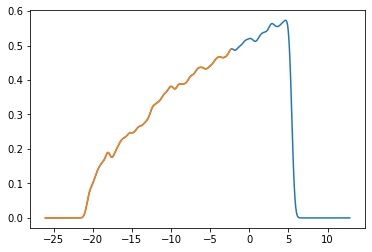

In [1209]:
%matplotlib inline
plt.plot(xdos, new_train_ldos[0])
plt.plot(xdos[:474], opt_shifted_train_preds[0])

### Evaluate the equivalent shift using normal ldos

In [1212]:
##Generate individual xdos, ldos
new_train_ldos = []

sigma = torch.tensor(0.3)
ndos = 778

emin = -24.5537 - 1.5
emax = 11.3464 + 1.5
x_dos = torch.linspace(emin, emax, 778)
for j, i in enumerate(tqdm(train_index)):
    
    l_dos = torch.sum(torch.exp(-0.5*((x_dos + best_state1[j] - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    new_train_ldos.append(l_dos[:474])

new_train_ldos = torch.vstack(new_train_ldos)
new_train_ldos = ((new_train_ldos.T * normalization[train_index] ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [01:01<00:00, 13.43it/s]


In [1213]:
##Generate individual xdos, ldos
new_test_ldos = []

sigma = torch.tensor(0.3)
ndos = 778

emin = -24.5537 - 1.5
emax = 11.3464 + 1.5
x_dos = torch.linspace(emin, emax, 778)
for j, i in enumerate(tqdm(test_index)):
    
    l_dos = torch.sum(torch.exp(-0.5*((x_dos + test_align[j]- full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    new_test_ldos.append(l_dos[:474])
    
new_test_ldos = torch.vstack(new_test_ldos)
new_test_ldos = ((new_test_ldos.T * normalization[test_index] ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:13<00:00, 15.29it/s]


In [1204]:
plt.plot(xdos, ldos[train_index[1]], c= 'b')
plt.plot(x_dos, new_train_ldos[1], c= 'g')
plt.plot(xdos, shifted_train_preds[1], c= 'r')

NameError: name 'shifted_train_preds' is not defined

In [ ]:
%matplotlib notebook
plt.plot(xdos, ldos[test_index[0]], c= 'b')
plt.plot(xdos, new_test_ldos[0].detach(), c= 'g')
plt.plot(xdos, shifted_test_preds[0], c= 'r')

In [1217]:
# shifted_target = shift_coeffs(new_train_ldos, emin, emax, best_state1) 
# shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,new_train_ldos.shape[1])])   
shifted_reg_target = torch.vstack([new_train_ldos, torch.zeros(n_col,new_train_ldos.shape[1])])

shifted_weights = torch.linalg.lstsq(reg_features.double(), shifted_reg_target, driver = "gelsd").solution

shifted_train_preds = Features.double() @ shifted_weights
shifted_test_preds = t_Features.double() @ shifted_weights

train_rmse = loss.t_get_rmse(shifted_train_preds, new_train_ldos, xdos[:474], perc = True)
test_rmse = loss.t_get_rmse(shifted_test_preds, new_test_ldos, xdos[:474], perc = True)

print ("Using Spline shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse)) 

Using Spline shifts, Train_rmse:8.16759, Test_rmse 9.66818


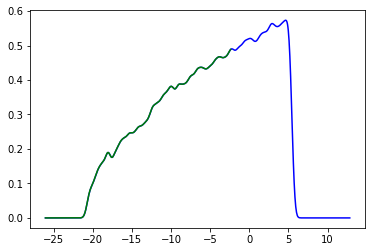

In [1220]:
plt.plot(xdos, ldos[train_index[0]], c= 'b')
plt.plot(xdos[:474], new_train_ldos[0], c= 'g')

In [ ]:
10.5, 17.4

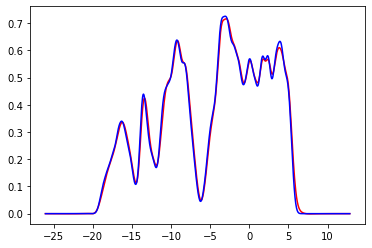

In [32]:
plt.plot(xdos, shifted_test_preds[0], c= 'r')
plt.plot(xdos, new_test_ldos[0].detach(), c= 'b')

In [67]:
# original_target = shift_coeffs(ldos[train_index], emin, emax, best_state1) 
# original_reg_target = torch.vstack([original_target, torch.zeros(n_col,ldos.shape[1])])   


original_reg_target = torch.vstack([ldos[train_index], torch.zeros(n_col,ldos.shape[1])])

original_weights = torch.linalg.lstsq(reg_features.double(), original_reg_target, driver = "gelsd").solution

original_train_preds = Features.double() @ original_weights
original_test_preds = t_Features.double() @ original_weights

train_rmse = loss.t_get_rmse(original_train_preds, ldos[train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(original_test_preds, ldos[test_index], xdos, perc = True)

print ("No shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse))

No shifts, Train_rmse:10.9057, Test_rmse 12.4247


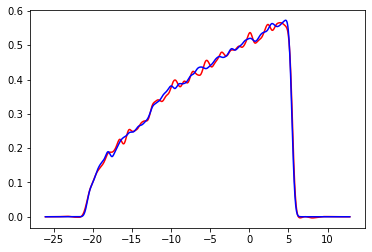

In [248]:
plt.plot(xdos, original_train_preds[0], c= 'r')
plt.plot(xdos, ldos[train_index[0]], c= 'b')

## For Biased Index

In [1226]:
from dostools.loss import loss
#normal dataset

batch_size = 32
sigma = 0.3
n_epochs = 100000
patience = 20

index = biased_train_index
t_index = biased_test_index

Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)])#.type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)])#.type(dtype = torch.complex128)
# Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
# t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
# alignment = torch.nn.parameter.Parameter((torch.rand(len(index))-0.5) *2 ) 

opt = torch.optim.Adam([alignment], lr = 1e-3, weight_decay = 0)
# opt_LBFGS = torch.optim.LBFGS([alignment], lr = 1e-3, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 20, threshold = 1e-5, min_lr = 1e-8)

xdos_i = xdos.clone()
# cutoff = torch.max(efermi) + 3
# cutoff_index = torch.searchsorted(xdos, cutoff)

train_ldos = manual_call2(Total_splines[index], xaxis, pred_xdos + alignment.view(-1,1))
test_ldos = manual_call2(Total_splines[t_index], xaxis, pred_xdos + torch.zeros(len(t_index)).view(-1,1))

best_mse = torch.tensor(100)
best_state = alignment.clone()

n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = loss.t_get_rmse(reference_pred, train_ldos, pred_xdos, perc = True)#torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = loss.t_get_rmse(reference_t_pred, test_ldos, pred_xdos, perc = True)#torch.mean(abs(reference_t_pred- test_ldos)**2) 
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))

pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), trigger = trigger)
    for i_batch in Batcher:
        def closure():
            opt.zero_grad()
            reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = manual_call2(Total_splines[index[i_batch]], xaxis, pred_xdos + alignment[i_batch].view(-1,1))
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
            train_weights = torch.linalg.lstsq(reg_features_i, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            shifted_train_preds = Features[i_batch] @ train_weights
            loss_i = loss.t_get_mse(shifted_train_preds, shifted_target)#torch.mean(abs(shifted_train_preds - shifted_target)**2) 
            loss_i.backward(inputs = alignment)
            return loss_i
        opt.step(closure)
        train_ldos = train_ldos.detach()
        
    with torch.no_grad():
        shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + alignment.view(-1,1))
        shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
        train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
        pred_i = Features @ train_weights
        
        
        i_loss = loss.t_get_rmse(pred_i, shifted_target)#torch.mean(abs(pred_i - shifted_target)**2) 
        pred_loss = loss.t_get_rmse(pred_i, shifted_target, pred_xdos, perc = True)
#         pred_loss = i_loss
        if i_loss < prev_loss * (1 + 1e-3): 
            trigger = 0
        else:
            trigger +=1 
            if trigger >= patience:
                alignment = torch.nn.parameter.Parameter(best_state)
                opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                counter = 0

        if i_loss < best_mse:
            best_mse = i_loss
            best_state = alignment.clone()

        prev_loss = i_loss

        scheduler.step(i_loss)
        if Batcher.batch_size > 1024:
            break
            
        if opt.param_groups[0]['lr'] < 1e-3:
            Batcher.batch_size *= 2 
            opt.param_groups[0]['lr'] = 1e-3
            print ("The batch_size is now:", Batcher.batch_size)

            
            


shifted_target = manual_call2(Total_splines[index], xaxis, pred_xdos + best_state.view(-1,1))
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,shifted_target.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = loss.t_get_rmse(shifted_preds, shifted_target, pred_xdos, perc = True)#torch.mean(abs(shifted_preds - shifted_target)**2)#
# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.6}".format(shifted_train_loss))


Reference training loss: 9.68362
Reference test loss : 16.9169


Epoch: 499:   0%|▌                                                                                                          | 499/100000 [08:53<29:09:30,  1.05s/it, lowest_mse=0.00624, pred_loss=7.97, trigger=0]

The batch_size is now: 64


Epoch: 634:   1%|▋                                                                                                          | 634/100000 [10:17<16:45:12,  1.65it/s, lowest_mse=0.00613, pred_loss=7.84, trigger=0]

The batch_size is now: 128


Epoch: 763:   1%|▊                                                                                                          | 763/100000 [11:07<12:23:22,  2.22it/s, lowest_mse=0.00608, pred_loss=7.79, trigger=0]

The batch_size is now: 256


Epoch: 1822:   2%|█▉                                                                                                         | 1822/100000 [15:44<6:24:34,  4.25it/s, lowest_mse=0.00582, pred_loss=7.5, trigger=0]

The batch_size is now: 512


Epoch: 2541:   3%|██▋                                                                                                       | 2541/100000 [18:00<5:37:52,  4.81it/s, lowest_mse=0.00572, pred_loss=7.41, trigger=0]

The batch_size is now: 1024


Epoch: 3020:   3%|███▏                                                                                                       | 3020/100000 [19:06<10:13:26,  2.63it/s, lowest_mse=0.0057, pred_loss=7.4, trigger=0]

The batch_size is now: 2048
Final training loss: 7.39511


In [46]:
biased_best_state = best_state.clone()

In [ ]:
torch.save(biased_best_state, "./Splines_biased_best_state_0.pt")

In [25]:
biased_best_state = torch.load("./biased_best_state2.pt")



In [1228]:
train_error, train_align = MSE_shift_spline(shifted_preds, pred_xdos, Total_splines[index], xaxis, 300)
test_error, test_align = MSE_shift_spline(shifted_t_preds, pred_xdos, Total_splines[t_index], xaxis, 300)
with torch.no_grad():
    original_ldos = manual_call2(Total_splines, xaxis, pred_xdos + torch.zeros(1039).view(-1,1))
    opt_shifted_train_preds = manual_call2(Total_splines[index], xaxis, pred_xdos + train_align.view(-1,1))
    shifted_train_loss = loss.t_get_rmse(shifted_preds, opt_shifted_train_preds, pred_xdos, perc = True)#torch.mean(abs(shifted_preds - shifted_target)**2)#
    print ("Train loss is {}".format(shifted_train_loss))
    
    opt_shifted_test_preds = manual_call2(Total_splines[t_index], xaxis, pred_xdos + test_align.view(-1,1))
    shifted_test_loss = loss.t_get_rmse(shifted_t_preds, opt_shifted_test_preds, pred_xdos, perc = True)#torch.mean(abs(shifted_preds - shifted_target)**2)#
    print ("Test loss is {}".format(shifted_test_loss))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 332.14it/s]


Train loss is 7.43613250071883
Test loss is 14.42680444575426


### Baseline no shift

In [26]:
emin = -24.553719539983 - 1.5
emax = 11.346414696331 + 1.5
index= biased_train_index
t_index = biased_test_index

Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)]).type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)]).type(dtype = torch.complex128)

xdos_i = xdos.clone()

train_ldos = coeffs[index,:].clone()


n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = torch.mean(abs(reference_t_pred- coeffs[t_index])**2) 


print ("Fourier Space")
print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))

train_rs = evaluate_dos_from_fourier(reference_pred, emin, emax, num_eval=778)
test_rs = evaluate_dos_from_fourier(reference_t_pred , emin, emax, num_eval=778)


train_rmse = loss.t_get_rmse(train_rs, f_ldos[index], xdos, perc = True)
test_rmse = loss.t_get_rmse(test_rs, f_ldos[t_index], xdos, perc = True)

print ("Real Space")
print ("Reference training loss: {:.6}".format(train_rmse))
print ("Reference test loss : {:.6}".format(test_rmse))

print ("Gaussian Space")
train_rmse = loss.t_get_rmse(train_rs, ldos[index], xdos, perc = True)
test_rmse = loss.t_get_rmse(test_rs, ldos[t_index], xdos, perc = True)

print ("Reference training loss: {:.6}".format(train_rmse))
print ("Reference test loss : {:.6}".format(test_rmse))




Fourier Space
Reference training loss: 0.00153287
Reference test loss : 0.00264829
Real Space
Reference training loss: 10.2953
Reference test loss : 16.2029
Gaussian Space
Reference training loss: 10.4205
Reference test loss : 16.2931


In [27]:
shifted_target = shift_coeffs(train_ldos, emin, emax, 1 * biased_best_state)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights

shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)
shifted_test_loss = MSE_shift_fourier(shifted_t_preds, coeffs[t_index], 5)

print ("Fourier Space: Train_loss: {:.6}, Test_loss:{:.6}".format(shifted_train_loss, shifted_test_loss[0]))


Fourier Space: Train_loss: 0.00134436, Test_loss:0.0023673


In [28]:
shifted_target = shift_coeffs(train_ldos, emin, emax, biased_best_state)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights

shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)
biased_shifted_test_loss = MSE_shift_fourier(shifted_t_preds, coeffs[t_index], 5)


zeroed_train_predictions = evaluate_dos_from_fourier(shift_coeffs(shifted_preds, emin, emax, -1 * biased_best_state) , emin, emax, num_eval=778)
zeroed_test_predictions = evaluate_dos_from_fourier(shift_coeffs(shifted_t_preds, emin, emax, 1 * biased_shifted_test_loss[1]) , emin, emax, num_eval=778)



train_rmse = loss.t_get_rmse(zeroed_train_predictions, f_ldos[biased_train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(zeroed_test_predictions, f_ldos[biased_test_index], xdos, perc = True)

print ("Real Space: Train_loss: {:.6}, Test_loss:{:.6}".format(train_rmse, test_rmse))

Real Space: Train_loss: 9.64147, Test_loss:15.3193


In [29]:
train_rmse = loss.t_get_rmse(zeroed_train_predictions, ldos[biased_train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(zeroed_test_predictions, ldos[biased_test_index], xdos, perc = True)

print ("Real Space to gaussian: Train_loss: {:.6}, Test_loss:{:.6}".format(train_rmse, test_rmse))

Real Space to gaussian: Train_loss: 9.77523, Test_loss:15.4148


In [30]:
biased_test_shift = biased_shifted_test_loss[1]
torch.save(biased_test_shift, "./biased_test_shift.pt")

### For gaussian dataset

In [52]:
##Generate individual xdos, ldos
new_biased_train_ldos = []

sigma = torch.tensor(0.3)
ndos = 778

emin = -24.5537 - 1.5
emax = 11.3464 + 1.5
x_dos = torch.linspace(emin, emax, 778)
for j, i in enumerate(tqdm(biased_train_index)):
    
    l_dos = torch.sum(torch.exp(-0.5*((x_dos + biased_best_state[j] - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    new_biased_train_ldos.append(l_dos)

new_biased_train_ldos = torch.vstack(new_biased_train_ldos)
new_biased_train_ldos = ((new_biased_train_ldos.T * normalization[biased_train_index] ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [01:07<00:00, 12.38it/s]


In [53]:
##Generate individual xdos, ldos
new_biased_test_ldos = []

sigma = torch.tensor(0.3)
ndos = 778

emin = -24.5537 - 1.5
emax = 11.3464 + 1.5
x_dos = torch.linspace(emin, emax, 778)
for j, i in enumerate(tqdm(biased_test_index)):
    
    l_dos = torch.sum(torch.exp(-0.5*((x_dos - biased_shifted_test_loss[1][j]- full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    new_biased_test_ldos.append(l_dos)
    
new_biased_test_ldos = torch.vstack(new_biased_test_ldos)
new_biased_test_ldos = ((new_biased_test_ldos.T * normalization[biased_test_index] ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:09<00:00, 21.78it/s]


In [54]:
# shifted_target = shift_coeffs(new_train_ldos, emin, emax, best_state1) 
# shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,new_train_ldos.shape[1])])   
shifted_reg_target = torch.vstack([new_biased_train_ldos, torch.zeros(n_col,new_biased_train_ldos.shape[1])])

shifted_weights = torch.linalg.lstsq(reg_features.double(), shifted_reg_target, driver = "gelsd", rcond = 1e-10).solution

shifted_train_preds = Features.double() @ shifted_weights
shifted_test_preds = t_Features.double() @ shifted_weights

train_rmse = loss.t_get_rmse(shifted_train_preds, new_biased_train_ldos, xdos, perc = True)
test_rmse = loss.t_get_rmse(shifted_test_preds, new_biased_test_ldos, xdos, perc = True)

print ("Using fourier shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse)) 

Using fourier shifts, Train_rmse:11.6673, Test_rmse 18.1646


In [55]:
# original_target = shift_coeffs(ldos[train_index], emin, emax, best_state1) 
# original_reg_target = torch.vstack([original_target, torch.zeros(n_col,ldos.shape[1])])   


original_reg_target = torch.vstack([ldos[biased_train_index], torch.zeros(n_col,ldos.shape[1])])

original_weights = torch.linalg.lstsq(reg_features.double(), original_reg_target, driver = "gelsd").solution

original_train_preds = Features.double() @ original_weights
original_test_preds = t_Features.double() @ original_weights

train_rmse = loss.t_get_rmse(original_train_preds, ldos[biased_train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(original_test_preds, ldos[biased_test_index], xdos, perc = True)

print ("No shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse))

No shifts, Train_rmse:10.3077, Test_rmse 16.2216


### Quartic Dataset

In [56]:
##Generate individual xdos, ldos
with torch.no_grad():
    biased_train_ldos2 = []

    sigma = torch.tensor(0.3)
    ndos = 778 #+ int(30/0.05)


    emin = -24.5537 - 1.5
    emax = 11.3464 + 1.5

    x_dos2 = torch.linspace(emin, emax, 778)

    for j,i in enumerate(tqdm(biased_train_index)):
        #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)    
        l_dos2 = quartic_dos(sorted_full_eigen_energies[i] + biased_best_state[j], x_dos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    #     n_xdos2.append(x_dos2)
        biased_train_ldos2.append(l_dos2)

    # n_xdos2 = torch.vstack(n_xdos2)
    biased_train_ldos2 = torch.vstack(biased_train_ldos2)
    biased_train_ldos2 = ((biased_train_ldos2.T * normalization_quartic[biased_train_index] ).T)* 2

#Do cutting here?

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [00:02<00:00, 324.02it/s]


In [57]:
##Generate individual xdos, ldos
with torch.no_grad():
    biased_test_ldos2 = []

    sigma = torch.tensor(0.3)
    ndos = 778 #+ int(30/0.05)


    emin = -24.5537 - 1.5
    emax = 11.3464 + 1.5

    x_dos2 = torch.linspace(emin, emax, 778)

    for j,i in enumerate(tqdm(biased_test_index)):
        #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)    
        l_dos2 = quartic_dos(sorted_full_eigen_energies[i] - shifted_test_loss[1][j], x_dos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    #     n_xdos2.append(x_dos2)
        biased_test_ldos2.append(l_dos2)

    # n_xdos2 = torch.vstack(n_xdos2)
    biased_test_ldos2 = torch.vstack(biased_test_ldos2)
    biased_test_ldos2 = ((biased_test_ldos2.T * normalization_quartic[biased_test_index] ).T)* 2

#Do cutting here?

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 446.12it/s]


In [58]:
# shifted_target = shift_coeffs(new_train_ldos, emin, emax, best_state1) 
# shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,new_train_ldos.shape[1])])   
shifted_reg_target = torch.vstack([biased_train_ldos2, torch.zeros(n_col,biased_train_ldos2.shape[1])])

shifted_weights = torch.linalg.lstsq(reg_features.double(), shifted_reg_target, driver = "gelsd").solution

shifted_train_preds = Features.double() @ shifted_weights
shifted_test_preds = t_Features.double() @ shifted_weights

train_rmse = loss.t_get_rmse(shifted_train_preds, biased_train_ldos2, xdos, perc = True)
test_rmse = loss.t_get_rmse(shifted_test_preds, biased_test_ldos2, xdos, perc = True)

print ("Using fourier shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse)) 

Using fourier shifts, Train_rmse:9.23298, Test_rmse 14.6728


In [59]:
# original_target = shift_coeffs(ldos[train_index], emin, emax, best_state1) 
# original_reg_target = torch.vstack([original_target, torch.zeros(n_col,ldos.shape[1])])   


original_reg_target = torch.vstack([quartic_ldos[biased_train_index], torch.zeros(n_col,ldos.shape[1])])

original_weights = torch.linalg.lstsq(reg_features.double(), original_reg_target, driver = "gelsd").solution

original_train_preds = Features.double() @ original_weights
original_test_preds = t_Features.double() @ original_weights

train_rmse = loss.t_get_rmse(original_train_preds, quartic_ldos[biased_train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(original_test_preds, quartic_ldos[biased_test_index], xdos, perc = True)

print ("No shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse))

No shifts, Train_rmse:9.85658, Test_rmse 15.5983


## Last